# Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets,models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
# Loading the Training and Testing Data
trainImages = np.load('./Flowers/flower_imgs.npy')
trainLabels = np.load('./Flowers/flower_labels.npy')
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.43430043 0.43250865 0.35484957], std: [0.28290703 0.26667351 0.25423616]


In [3]:
class FlowerLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

## Normalizing about mean and variance
* Also defining Train and Test Data Loaders
* Train Data Loader has shuffle = True; This will ensure that every epoch the data in each minibatch will be shuffled, which ideal to prevent overfitting.
* MiniBatch of 64 is chosen, as Testing accuracy ranges around 74 -78 percent with other sizes like 128 or 256.
* Data Augmentation is enabled for train loader again to decrease overfitting.
* For Test Loader only the normalized parameter is used. This is to ensure that we get the right accuracy. 

In [4]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =64

train_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
test_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])), shuffle=False)

# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

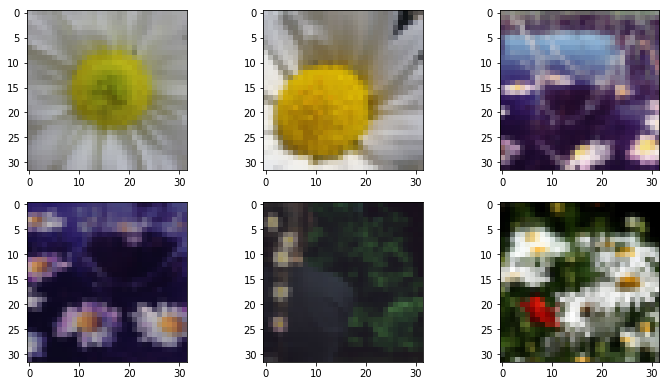

In [5]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainImages[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. After taking suggestions from comments on Piazza, I tried implementing VGG.
* After Implementing different VGG Networks, VGG13 gave the best results. 
* I modified the original network to increase accuracy from 80 to 83 percent. This was due to changing the activation function and using dropouts.


In [6]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256,'D', 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU()]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 5)]
        layers += [nn.Sigmoid()]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG11')
net.to(device)

VGG(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [7]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           1,792
       BatchNorm2d-2           [64, 64, 32, 32]             128
              ReLU-3           [64, 64, 32, 32]               0
         MaxPool2d-4           [64, 64, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]          73,856
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
         MaxPool2d-8            [64, 128, 8, 8]               0
            Conv2d-9            [64, 256, 8, 8]         295,168
      BatchNorm2d-10            [64, 256, 8, 8]             512
             ReLU-11            [64, 256, 8, 8]               0
           Conv2d-12            [64, 256, 8, 8]         590,080
      BatchNorm2d-13            [64, 256, 8, 8]             512
             ReLU-14            [64, 25

##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below.

# Add image


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

# Inferences
* The same model was used as used in MNIST. The model seems to be working good with only increase in number of Epochs to 20. the batch size was reduced to to 64 for more updates.
* Before using the same model I tried Fashion MNISt with other models as well. Below are the accuracy received with each model:
    * With 3 Dense (fully connected layers); Test Accuracy after 12 epochs was; 90.82 %
    * With 2 Dense and 1 convolution : Test Accuracy after 12 epochs: 91.11 %
    * With 2 Dense and 2 convolution: Test Accuracy is after 12 epochs : 91.74 %
    * Therefore, the final option was adopted.
* Therefore, when there is image data, use of conv2D layers  help in feature exraction.
* There are 2 Convolution Layers and 2 Dense or Fully Connected Layers with subsequent Max Pooling and Dropout Layer.
* The number of hidden units in each layer are experimentally fine tuned. The units were experimented in 2^n multiples like 16, 32 , 64 ,128 , 256. 
* ** Input Conv2D layer: ** The weights are initialized by Glorot uniform initializer, which is the default. This is set as the values are nicely zero centered and within -1 and 1.The biases are set to zero as it improves the accuracy by 0.14 as compared to randomly distribued values between (-1 and 1)(found out by experimnetation).This is also recommended as per in CS231 from Standord. 
    * The kernel size is set to minimum of (3,3). This is because the image size is already small (28,28) and by using large kernel size there wont be enough data left to add more convolution layers.
    * the activation is set to RELU, as it is the most recommended and also as the input is normalized between 0 and 1.
* ** Max Pooling layer: ** for pooling Max Pooling is used. Again as the input size is very less. The maxpooling kernel size is set to (2,2). This works as there is still enough information in a (2,2) window and it also does not throw out a lot of valuable data.
* ** Drop Out: ** This is very Essential as it helps prevent over fitting. Two dropout layers are used. 
    * The first one is in between convolution layers. The dropout of 0.25 was determined to be optimal. At this vlaue the convergence of Training accuracy to validation accuracy was smooth and gradual as compared to other values.
    * The second dropout was used just before the final fully connected layer. This is kept at 0.45 as experimnetally determined and is used to reduce overfitting.
* ** Dense Layers: ** Two fully connect layers are used with a dropput in between. This seems to give good performances in MNIST and Fashion MNIST.
    * For final fully connected layer, softmax is used as activation. This is because there are a total of 10 classes and the predicted output can exactly be any one of these classes.
* ** Loss ** : as one hot encoding is used, categorical_crossentropy loss is used as loss function. This is used as it is the most recommended one.
* ** Optimizer ** : Different Optimizers were tried out. Even for Fashion MNIST, for different optimizers there was not a lot of change in the convergence time or the number of epochs. 
    * For example, I used Adadelta and each epoch took 4.5 seconds less to finish as compared to Adam, also the final test accuracy was higher for Adadelta. Therefore I finally decided to use Adadelta as my optimizers. After playing with the parmaters, I come to the conclusion that the default value works the best.

In [9]:
# For Debugging
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     # loss.backward()
#     # optimizer.step()
#     break
# target

## Training and Testing Functions

In [10]:
def train(model, train_loader, optimizer, epoch,device):
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
device

device(type='cuda', index=0)

# Training the Model

In [12]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/3674 (0%)]	Loss: 1.604951
Train Epoch: 1 [1280/3674 (34%)]	Loss: 1.347053
Train Epoch: 1 [2560/3674 (69%)]	Loss: 1.318015


KeyboardInterrupt: 

Training Loss: 1.394344975208414
Training Accuracy: 43.4676102340773

Test Loss: 1.616944457974015
Testing Accuracy: 21.571648690292758



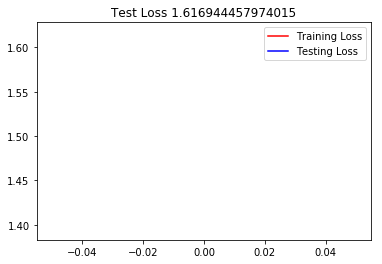

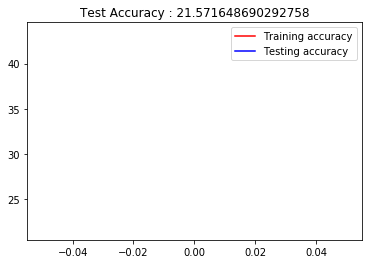

In [13]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

# Incorrect Predictions


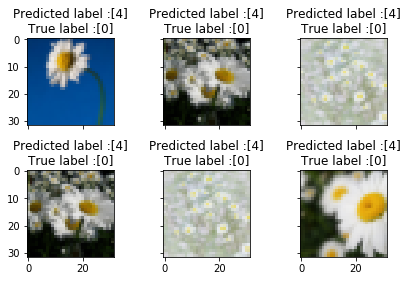

In [122]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
    output = net(data)
            #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
            # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(ans, -n)[-n:]

#======= Plotting=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()
